In [1]:
# !pip install -U git+https://github.com/theislab/ehrapy

Missing Data Bias and Imputation Bias

In [2]:
import ehrapy as ep
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
# from ehrapy-tutorials/bias_utils import plot_hist_num_medication, plot_hist_normalization

/Users/eljasroellin/Documents/ehrapy_theislab/ehrapy_venv_may/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
VAR_OF_INTEREST = "num_medications" # num_medications time_in_hospital
GROUP_VAR = "discharge_disposition_id" # medical_specialty discharge_disposition_id

discharge_disposition_id
'Discharged to Home'    60234
Other                   41532
Name: count, dtype: int64


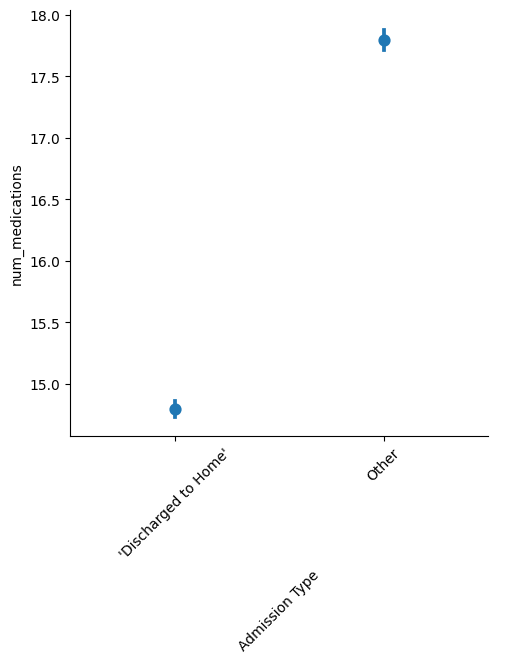

In [5]:
adata = ep.dt.diabetes_130_fairlearn()
adata = ep.ad.move_to_obs(adata, ["num_medications", "time_in_hospital", "discharge_disposition_id"], copy_obs=True)

print(adata.obs[GROUP_VAR].value_counts())


# adata_trial = adata.copy()
# ep.ad.move_to_obs(adata_trial, ["medical_specialty", "admission_source_id"], copy_obs=True)
sns.catplot(
    y=VAR_OF_INTEREST,
    x=GROUP_VAR,
    data=adata.obs,
    kind="point",
    ci=95,
    dodge=True,
    join=False,
)
plt.xlabel("Admission Type", rotation=45)
plt.xticks(rotation=45)
plt.ylabel(VAR_OF_INTEREST)

plt.show()

In [6]:
adata = ep.dt.diabetes_130_fairlearn()
adata = ep.ad.move_to_obs(adata, [GROUP_VAR])

In [7]:
# create reproducible MCAR missing values
rng = np.random.default_rng(2)
mcar_mask = rng.choice([True, False], size=len(adata), p=[0.3, 0.7])
# create a new AnnData with these missing values
adata_mcar = adata.copy()
adata_mcar.X[mcar_mask, adata_mcar.var_names == VAR_OF_INTEREST] = np.nan

In [8]:
adata_mcar_mean_imputed = ep.pp.simple_impute(
    adata_mcar, var_names=[VAR_OF_INTEREST], strategy="mean", copy=True
)

In [9]:
adata_mcar_limited = adata_mcar[:, adata_mcar.var_names.isin([VAR_OF_INTEREST, "time_in_hospital"])].copy()

In [10]:
ep.ad.infer_feature_types(adata_mcar_limited)

 Detected feature types for AnnData object with 101766 obs and 2 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╚══ num_medications
╚══ 🗂️ Categorical features
    ╚══ time_in_hospital (14 categories)

<Axes: >

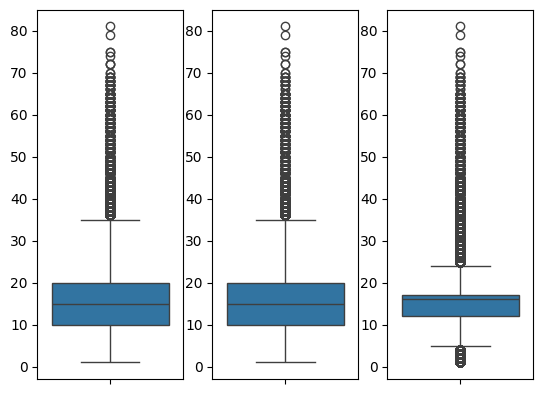

In [11]:
fig, axs = plt.subplots(1, 3)

sns.boxplot(y=adata[:,adata.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[0])
sns.boxplot(y=adata_mcar[:,adata_mcar.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[1])
sns.boxplot(y=adata_mcar_mean_imputed[:,adata_mcar_mean_imputed.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[2])
# sns.boxplot(y=adata_mcar_mi_imputed[:,adata_mcar_mi_imputed.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[3])

<Axes: xlabel='discharge_disposition_id'>

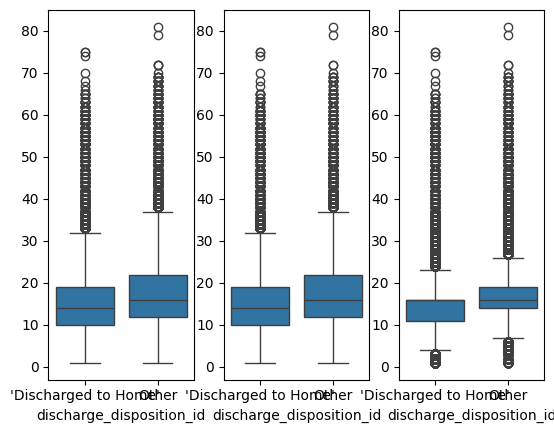

In [12]:
fig, axs = plt.subplots(1, 3)

sns.boxplot(y=adata[:,adata.var_names==VAR_OF_INTEREST].X.flatten(), x=adata.obs[GROUP_VAR], ax=axs[0])
sns.boxplot(y=adata_mcar[:,adata_mcar.var_names==VAR_OF_INTEREST].X.flatten(), x=adata_mcar.obs[GROUP_VAR], ax=axs[1])
sns.boxplot(y=adata_mcar_mean_imputed[:,adata_mcar_mean_imputed.var_names==VAR_OF_INTEREST].X.flatten(), x=adata_mcar_mean_imputed.obs[GROUP_VAR], ax=axs[2])


<Axes: ylabel='value'>

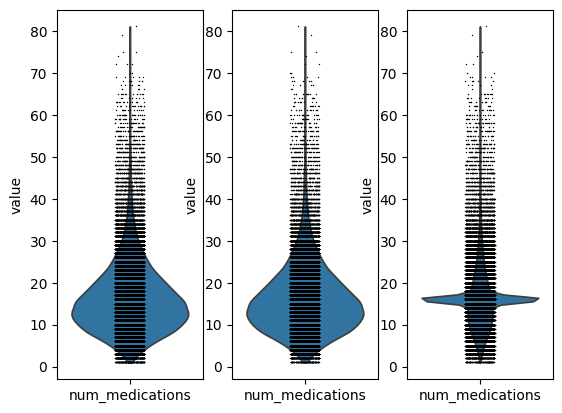

In [13]:
fig, axs = plt.subplots(1, 3)

ep.pl.violin(adata, keys=VAR_OF_INTEREST, ax=axs[0], show=False)
ep.pl.violin(adata_mcar, keys=VAR_OF_INTEREST, ax=axs[1], show=False)
ep.pl.violin(adata_mcar_mean_imputed, keys=VAR_OF_INTEREST, ax=axs[2], show=False)


<Axes: xlabel='discharge disposition id', ylabel='num_medications'>

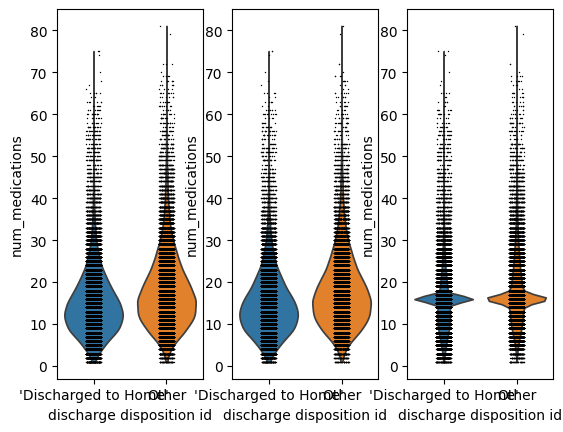

In [14]:
fig, axs = plt.subplots(1, 3)

ep.pl.violin(adata, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[0], show=False)
ep.pl.violin(adata_mcar, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[1], show=False)
ep.pl.violin(adata_mcar_mean_imputed, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[2], show=False)


In [15]:
adata_group = adata[:, adata.var_names.isin([VAR_OF_INTEREST, "time_in_hospital"])]

# admission_source_encoded = adata_group_encoded[:, adata_group_encoded.var_names == f"ehrapycat_{GROUP_VAR}"].X
value_vector = adata[:,adata.var_names=="time_in_hospital"].X.astype(np.float64)

continuous_values = np.array(
    value_vector - np.mean(value_vector)
) / np.std(value_vector)
# small offset to steer the degree of missingness
continuous_values *= 1.2
continuous_values -= 0.6
# continuous_values=admission_source_encoded

# Convert continuous values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-continuous_values))
probabilities

# Generate MAR mask based on probabilities
rng = np.random.default_rng(2)
mar_mask = rng.binomial(1, probabilities).astype(bool)

adata_group_encoded_mar = adata_group.copy()
adata_group_encoded_mar.X[mar_mask.flatten(), adata_group_encoded_mar.var_names == VAR_OF_INTEREST] = np.nan
# adata_mar.obs = adata_mar.obs.drop([VAR_OF_INTEREST], axis=1)
# adata_mar = ep.ad.move_to_obs(adata_mar, [VAR_OF_INTEREST])

In [16]:
mar_mask.flatten().sum()/len(mar_mask)

In [17]:
adata_mar_mean_imputed = ep.pp.simple_impute(
    adata_group_encoded_mar, var_names=[VAR_OF_INTEREST], strategy="mean", copy=True
)

In [18]:
adata_mar_mi_imputed = ep.pp.miss_forest_impute(adata_group_encoded_mar, copy=True)

❗ The number of jobs is only 1. To decrease the runtime set ep.settings.n_jobs=-1.


<Axes: xlabel='discharge_disposition_id'>

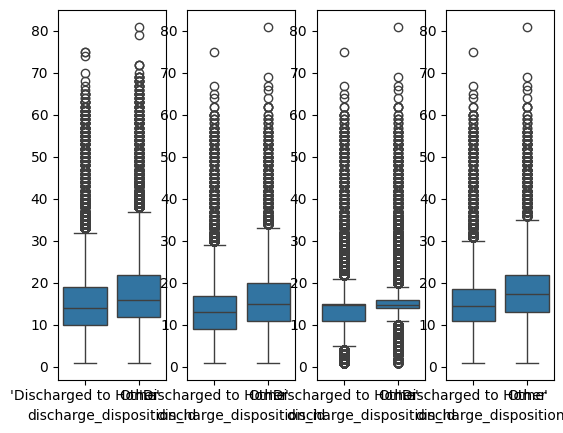

In [19]:
fig, axs = plt.subplots(1, 4)

sns.boxplot(y=adata[:,adata.var_names==VAR_OF_INTEREST].X.flatten(), x=adata.obs[GROUP_VAR], ax=axs[0])
sns.boxplot(y=adata_group_encoded_mar[:,adata_group_encoded_mar.var_names==VAR_OF_INTEREST].X.flatten(), x=adata_group_encoded_mar.obs[GROUP_VAR], ax=axs[1])
sns.boxplot(y=adata_mar_mean_imputed[:,adata_mar_mean_imputed.var_names==VAR_OF_INTEREST].X.flatten(), x=adata_mar_mean_imputed.obs[GROUP_VAR], ax=axs[2])
sns.boxplot(y=adata_mar_mi_imputed[:,adata_mar_mi_imputed.var_names==VAR_OF_INTEREST].X.flatten(), x=adata_mar_mi_imputed.obs[GROUP_VAR], ax=axs[3])


<Axes: ylabel='value'>

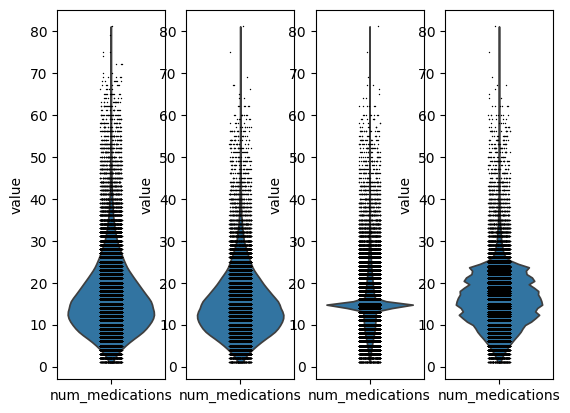

In [21]:
fig, axs = plt.subplots(1, 4)

ep.pl.violin(adata, keys=VAR_OF_INTEREST, ax=axs[0], show=False)
ep.pl.violin(adata_group_encoded_mar, keys=VAR_OF_INTEREST, ax=axs[1], show=False)
ep.pl.violin(adata_mar_mean_imputed, keys=VAR_OF_INTEREST, ax=axs[2], show=False)
ep.pl.violin(adata_mar_mi_imputed, keys=VAR_OF_INTEREST, ax=axs[3], show=False)


<Axes: xlabel='discharge disposition id', ylabel='num_medications'>

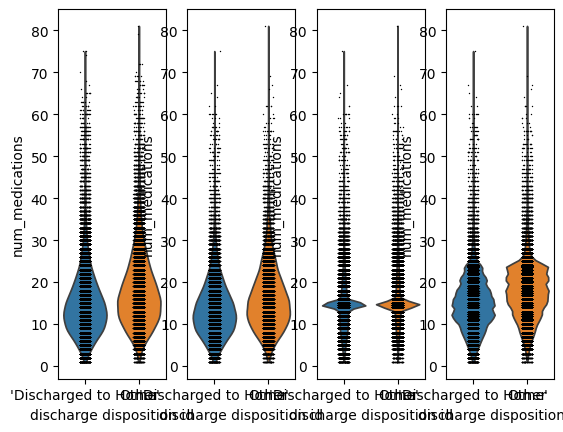

In [22]:
fig, axs = plt.subplots(1, 4)

ep.pl.violin(adata, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[0], show=False)
ep.pl.violin(adata_group_encoded_mar, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[1], show=False)
ep.pl.violin(adata_mar_mean_imputed, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[2], show=False)
ep.pl.violin(adata_mar_mi_imputed, keys=VAR_OF_INTEREST, groupby=GROUP_VAR, ax=axs[3], show=False)


In [23]:
adata_mcar_mean_imputed[:, adata_mcar_mean_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64)

ArrayView([[16.0236047],
           [16.0236047],
           [13.       ],
           ...,
           [ 9.       ],
           [16.0236047],
           [16.0236047]])

In [24]:
mean_complete = np.nanmean(adata[:, adata.var_names == VAR_OF_INTEREST].X.astype(np.float64))
mean_mcar = np.nanmean(adata_mcar[:, adata_mcar.var_names == VAR_OF_INTEREST].X.astype(np.float64))
mean_mcar_mean_imputed = np.nanmean(adata_mcar_mean_imputed[:, adata_mcar_mean_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))
mean_mar = np.nanmean(adata_group_encoded_mar[:, adata_group_encoded_mar.var_names == VAR_OF_INTEREST].X.astype(np.float64))
mean_mar_mean_imputed = np.nanmean(adata_mar_mean_imputed[:, adata_mar_mean_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))
mean_mar_mi_imputed = np.nanmean(adata_mar_mi_imputed[:, adata_mar_mi_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))

std_complete = np.nanstd(adata[:, adata.var_names == VAR_OF_INTEREST].X.astype(np.float64))
std_mcar = np.nanstd(adata_mcar[:, adata_mcar.var_names == VAR_OF_INTEREST].X.astype(np.float64))
std_mcar_mean_imputed = np.nanstd(adata_mcar_mean_imputed[:, adata_mcar_mean_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))
std_mar = np.nanstd(adata_group_encoded_mar[:, adata_group_encoded_mar.var_names == VAR_OF_INTEREST].X.astype(np.float64))
std_mar_mean_imputed = np.nanstd(adata_mar_mean_imputed[:, adata_mar_mean_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))
std_mar_mi_imputed = np.nanstd(adata_mar_mi_imputed[:, adata_mar_mi_imputed.var_names == VAR_OF_INTEREST].X.astype(np.float64))

df = pd.DataFrame(
    {   
        "Complete": [mean_complete, std_complete],
        "MCAR": [mean_mcar, std_mcar],
        "MCAR Mean Imputed": [mean_mcar_mean_imputed, std_mcar_mean_imputed],
        # "MAR": [mean_mar, std_mar],
        # "MAR Mean Imputed": [mean_mar_mean_imputed, std_mar_mean_imputed],
        # "MAR Imputed": [mean_mar_mi_imputed, std_mar_mi_imputed],
    },
    index=["Mean", "Stdev"]
)
df.style.format("{:.2f}")

,Complete,MCAR,MCAR Mean Imputed
Mean,16.02,16.02,16.02
Stdev,8.13,8.14,6.81


In [25]:
df_mcar = pd.DataFrame(
    {   
        "Complete": [mean_complete, std_complete],
        "MCAR": [mean_mcar, std_mcar],
        "MCAR Mean Imputed": [mean_mcar_mean_imputed, std_mcar_mean_imputed],
    },
    index=["Mean", "Stdev"]
)
df_mcar.style.format("{:.2f}")

,Complete,MCAR,MCAR Mean Imputed
Mean,16.02,16.02,16.02
Stdev,8.13,8.14,6.81


In [26]:
df_mar = pd.DataFrame(
    {   
        "Complete": [mean_complete, std_complete],
        "MAR": [mean_mar, std_mar],
        "MAR Mean Imputed": [mean_mar_mean_imputed, std_mar_mean_imputed],
        "MAR Imputed": [mean_mar_mi_imputed, std_mar_mi_imputed],
    },
    index=["Mean", "Stdev"]
)
df_mar.style.format("{:.2f}")

,Complete,MAR,MAR Mean Imputed,MAR Imputed
Mean,16.02,14.66,14.66,16.04
Stdev,8.13,7.20,5.72,6.45


Text(1.05, 0.2, 'Mean: 16.04\nStd Dev: 6.45')

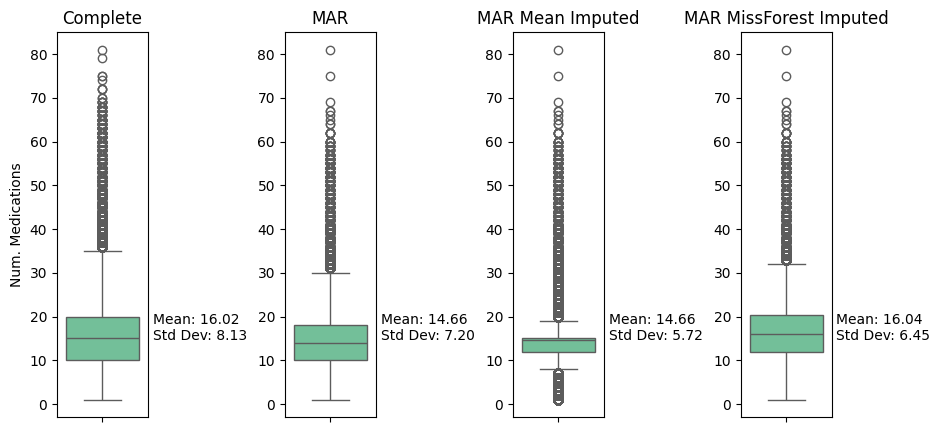

In [27]:
fig, axs = plt.subplots(1, 4, gridspec_kw={"wspace": 1.5}, figsize=(10, 5))

sns.boxplot(y=adata[:,adata.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[0], palette=["#66CC99"])
axs[0].set_title("Complete")
axs[0].set_ylabel("Num. Medications")
axs[0].text(1.05, 0.2, f"Mean: {mean_complete:.2f}\nStd Dev: {std_complete:.2f}", transform=axs[0].transAxes)

sns.boxplot(y=adata_group_encoded_mar[:,adata_group_encoded_mar.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[1], palette=["#66CC99"])
axs[1].set_title("MAR")
axs[1].text(1.05, 0.2, f"Mean: {mean_mar:.2f}\nStd Dev: {std_mar:.2f}", transform=axs[1].transAxes)

sns.boxplot(y=adata_mar_mean_imputed[:,adata_mar_mean_imputed.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[2], palette=["#66CC99"])
axs[2].set_title("MAR Mean Imputed")
axs[2].text(1.05, 0.2, f"Mean: {mean_mar_mean_imputed:.2f}\nStd Dev: {std_mar_mean_imputed:.2f}", transform=axs[2].transAxes)


sns.boxplot(y=adata_mar_mi_imputed[:,adata_mar_mi_imputed.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[3], palette=["#66CC99"])
axs[3].set_title("MAR MissForest Imputed")
axs[3].text(1.05, 0.2, f"Mean: {mean_mar_mi_imputed:.2f}\nStd Dev: {std_mar_mi_imputed:.2f}", transform=axs[3].transAxes)

# plt.savefig("missing-data_imputation_bias_mar.png", dpi=300, bbox_inches="tight")

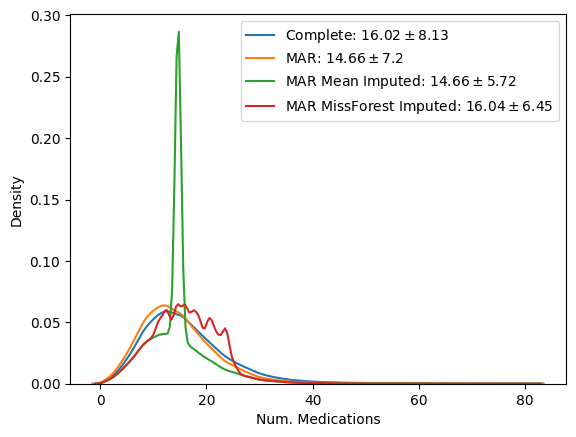

In [28]:
labels = ("Complete", "MAR", "MAR Mean Imputed", "MAR MissForest Imputed")
adatas = (adata, adata_group_encoded_mar, adata_mar_mean_imputed, adata_mar_mi_imputed)
colors = sns.color_palette("tab10")[:len(adatas)]

for i, (color, label, data) in enumerate(zip(colors, labels, adatas)):
    statistics = df_mar.iloc[:, i]
    stat_string = f"${round(statistics['Mean'].item(), 2)} \pm {round(statistics['Stdev'].item(), 2)}$"
    
    sns.kdeplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        palette=[color],
        label=f"{label}: {stat_string}"
    )
    
#     sns.rugplot(
#         x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
#         color=color,
#         y=0.025 * i
#     )
    
plt.xlabel("Num. Medications")
plt.legend()

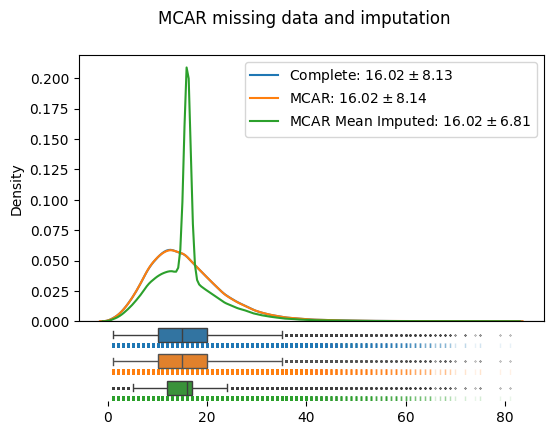

In [29]:
labels = ("Complete", "MCAR", "MCAR Mean Imputed")
adatas = (adata, adata_mcar, adata_mcar_mean_imputed)
colors = sns.color_palette("tab10")[:len(adatas)]

height_ratios = [10] + [1] * len(adatas)

# Create the subplots with specified height ratios
fig, axes = plt.subplots(
    nrows=1 + len(adatas),
    figsize=(6, 1.5 * len(adatas)),
    gridspec_kw={'height_ratios': height_ratios},
    sharex=True,
)
fig.subplots_adjust(hspace=0)

for i, (color, label, data) in enumerate(zip(colors, labels, adatas)):
    statistics = df_mcar.iloc[:, i]
    stat_string = f"${round(statistics['Mean'].item(), 2)} \pm {round(statistics['Stdev'].item(), 2)}$"
    
    sns.kdeplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        color=color,
        ax=axes[0],
        label=f"{label}: {stat_string}",
    )
    sns.boxplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        orient="h", 
        color=color,
        ax=axes[i + 1],
        width=0.25,
        fliersize=0.3
    )
    sns.rugplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        color=color,
        alpha=0.1,
        ax=axes[i + 1],
        height=0.2
    )
    
    axes[i+1].spines["right"].set_visible(False)
    axes[i+1].spines["left"].set_visible(False)
    axes[i+1].spines["bottom"].set_visible(False)
    axes[i+1].set_yticks([])

    if i > 0:
        axes[i+1].spines["top"].set_visible(False)
    
fig.suptitle("MCAR missing data and imputation", )
axes[0].legend()

plt.savefig("missing-data_imputation_bias_mcar.png", dpi=300, bbox_inches="tight")

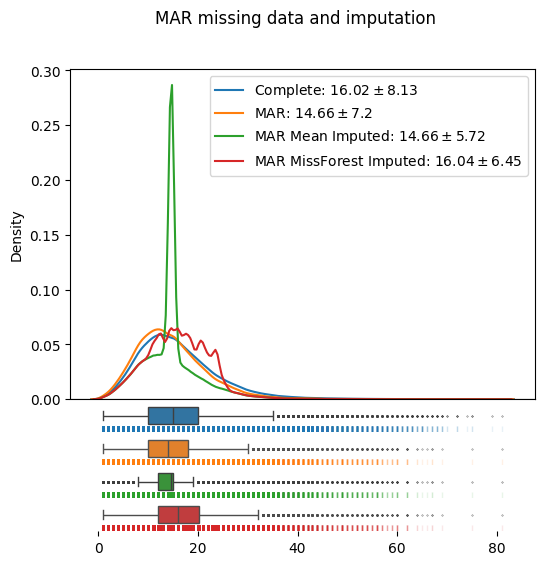

In [30]:
labels = ("Complete", "MAR", "MAR Mean Imputed", "MAR MissForest Imputed")
adatas = (adata, adata_group_encoded_mar, adata_mar_mean_imputed, adata_mar_mi_imputed)
colors = sns.color_palette("tab10")[:len(adatas)]

height_ratios = [10] + [1] * len(adatas)

# Create the subplots with specified height ratios
fig, axes = plt.subplots(
    nrows=1 + len(adatas),
    figsize=(6, 1.5 * len(adatas)),
    gridspec_kw={'height_ratios': height_ratios},
    sharex=True,
)
fig.subplots_adjust(hspace=0)

for i, (color, label, data) in enumerate(zip(colors, labels, adatas)):
    statistics = df_mar.iloc[:, i]
    stat_string = f"${round(statistics['Mean'].item(), 2)} \pm {round(statistics['Stdev'].item(), 2)}$"
    
    sns.kdeplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        color=color,
        ax=axes[0],
        label=f"{label}: {stat_string}",
    )
    sns.boxplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        orient="h", 
        color=color,
        ax=axes[i + 1],
        width=0.25,
        fliersize=0.3
    )
    sns.rugplot(
        x=data[:, data.var_names==VAR_OF_INTEREST].X.flatten(),
        color=color,
        alpha=0.1,
        ax=axes[i + 1],
        height=0.2
    )
    
    axes[i+1].spines["right"].set_visible(False)
    axes[i+1].spines["left"].set_visible(False)
    axes[i+1].spines["bottom"].set_visible(False)
    axes[i+1].set_yticks([])

    if i > 0:
        axes[i+1].spines["top"].set_visible(False)
    
fig.suptitle("MAR missing data and imputation", )
axes[0].legend()

plt.savefig("missing-data_imputation_bias_mar.png", dpi=300, bbox_inches="tight")

Text(1.05, 0.2, 'Mean: 16.02\nStd Dev: 6.81')

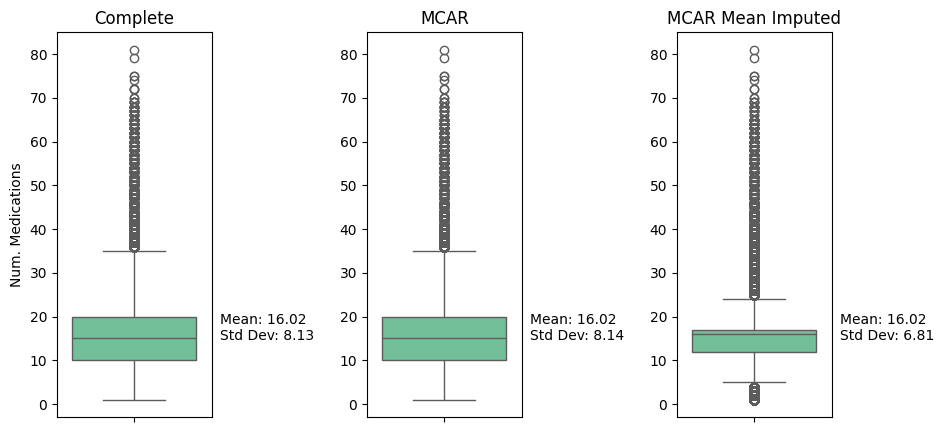

In [31]:
fig, axs = plt.subplots(1, 3, gridspec_kw={"wspace": 1.0}, figsize=(10, 5))

sns.boxplot(y=adata[:,adata.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[0], palette=["#66CC99"])
axs[0].set_title("Complete")
axs[0].set_ylabel("Num. Medications")
axs[0].text(1.05, 0.2, f"Mean: {mean_complete:.2f}\nStd Dev: {std_complete:.2f}", transform=axs[0].transAxes)

sns.boxplot(y=adata_mcar[:,adata_mcar.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[1], palette=["#66CC99"])
axs[1].set_title("MCAR")
axs[1].text(1.05, 0.2, f"Mean: {mean_mcar:.2f}\nStd Dev: {std_mcar:.2f}", transform=axs[1].transAxes)

sns.boxplot(y=adata_mcar_mean_imputed[:,adata_mcar_mean_imputed.var_names==VAR_OF_INTEREST].X.flatten(), ax=axs[2], palette=["#66CC99"])
axs[2].set_title("MCAR Mean Imputed")
axs[2].text(1.05, 0.2, f"Mean: {mean_mcar_mean_imputed:.2f}\nStd Dev: {std_mcar_mean_imputed:.2f}", transform=axs[2].transAxes)

# plt.savefig("missing-data_imputation_bias_mcar.png", dpi=300, bbox_inches="tight")